In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
from pandas.api.types import CategoricalDtype
from matplotlib import rcParams

In [2]:
from statsmodels.tsa.ar_model import AutoReg
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statistics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from matplotlib import rcParams
import seaborn as sns

In [3]:
#Read the file

city_hour = pd.read_csv("city_hour.csv")

In [4]:
#First 5 rows

city_hour.head(5)

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN


In [5]:
#Shape of the file

city_hour.shape

(707875, 16)

In [6]:
#Basic Summary for the same

city_hour.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,562787.000000,411138.000000,591243.000000,590753.000000,584651.000000,435333.000000,621358.000000,577502.000000,578667.000000,544229.000000,487268.000000,252046.000000,578795.000000
mean,67.622994,119.075804,17.421755,28.885157,32.287565,23.607959,2.183539,14.038307,34.798979,3.087595,8.660927,3.130537,166.413500
std,74.730496,104.224752,32.095211,29.162194,39.756669,28.831900,10.970514,19.305540,29.806379,16.456599,21.741023,7.834832,162.112729
min,0.010000,0.010000,0.010000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,8.000000
25%,26.200000,52.380000,3.840000,10.810000,10.660000,8.120000,0.420000,4.880000,13.420000,0.050000,0.370000,0.100000,79.000000
50%,46.420000,91.500000,7.960000,20.320000,20.790000,15.380000,0.800000,8.370000,26.240000,0.860000,2.590000,0.790000,116.000000
75%,79.490000,147.520000,16.150000,36.350000,37.150000,29.230000,1.370000,14.780000,47.620000,2.750000,8.410000,3.120000,208.000000
max,999.990000,1000.000000,499.990000,499.510000,498.610000,499.970000,498.570000,199.960000,497.620000,498.070000,499.400000,499.990000,3133.000000


### Separating Delhi from the rest

In [7]:
# Extracting just the city, Delhi

delhi_hour = city_hour[city_hour['City']=='Delhi']
delhi_hour.loc[293363]

City                        Delhi
Datetime      2020-07-01 00:00:00
PM2.5                       54.01
PM10                       128.66
NO                           6.33
NO2                         21.05
NOx                         16.81
NH3                         29.06
CO                           0.97
SO2                         11.15
O3                          29.73
Benzene                      2.03
Toluene                     23.57
Xylene                       0.65
AQI                         101.0
AQI_Bucket               Moderate
Name: 293363, dtype: object

### Showing the Relationship brtween the other pollutants

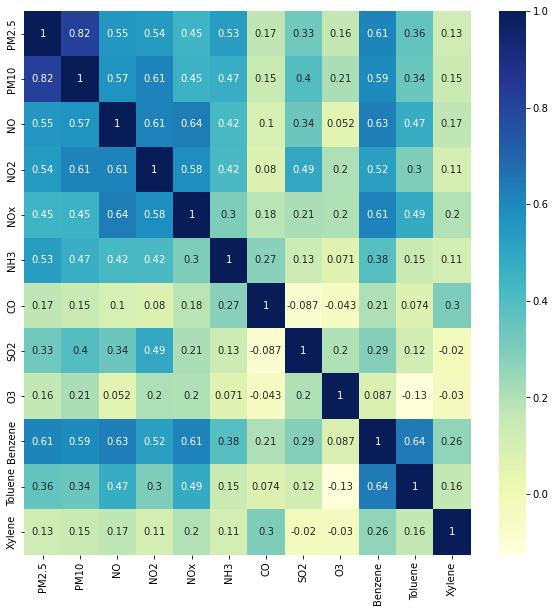

In [8]:
# plotting correlation heatmap
plt.figure(figsize=(10,10)) 
dataplot = sns.heatmap(delhi_hour.iloc[:,2:14].corr(), cmap="YlGnBu", annot=True)
 
# displaying heatmap
plt.show()

In [9]:
#Rolling Average of past 24hrs for certain pollutants, where there has to be at least 16 entries recorded in the
#past 24 hours

def roll24avg(df):
    for i in [2,3,6,7,9]:
        df.loc[:,df.columns[i]+'24avg'] = (df[df.columns[i]].rolling(window = 24, min_periods = 16).mean())
        
    return df
    

#Max of the past 8 hours for certain pollutants
def roll8max(df):
    for i in [8,10]:
        df.loc[:,df.columns[i]+'8max'] = (df[df.columns[i]].rolling(window = 8, min_periods = 1).max())
        
    return df

In [10]:
#Creating appropriate DateTime Objects for Timestamp

delhi_hour['DT'] = delhi_hour['Datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

#Applying the Averaging Functions for pollutants to get AQI Subindex
delhi_hour = roll24avg(delhi_hour)
delhi_hour = roll8max(delhi_hour)


#Calculte Subindex for each Pollutant

#bins decide the Breakingpoints(BP_Lo and BP_Hi) in the fomrula
bins_pm25 = pd.IntervalIndex.from_tuples([(0, 30), (30, 60), (60, 90), (90,120),(120,250),(250,np.inf)], closed='right')
#The following Line decides the AQI Bucket, which deicdes I_lo and I_hi in the formula
aqi_ind = [(0,50),(51,100),(101,200),(201,300),(301,400),(401,500)]
#This creates a dictionary of the two
pm25_aq = dict(zip(bins_pm25, aqi_ind))
#The follwoing assigns the Breaking Point Buvket to the pollutant based on the concentration recorded
delhi_hour.loc[:,'pm25cut'] = pd.cut(delhi_hour['PM2.524avg'], bins = bins_pm25, labels = bins_pm25)
#This then combines the Breaking Point Bucket with the corresponding AQI Bucket, and caluclates the formula
delhi_hour.loc[:,'pm25cut'] = delhi_hour.apply(lambda x: pm25_aq[x['pm25cut']][0] + ((x['PM2.524avg']-x['pm25cut'].left)*((pm25_aq[x['pm25cut']][1] - pm25_aq[x['pm25cut']][0])/(x['pm25cut'].right - x['pm25cut'].left)))  if not pd.isna(x['PM2.524avg']) else np.nan, axis = 1)



bins_pm10 = pd.IntervalIndex.from_tuples([(0, 50), (50, 100), (100, 250), (250,350),(350,430),(430,np.inf)], closed='right')
pm10_aq = dict(zip(bins_pm10, aqi_ind))
delhi_hour['pm10cut'] = pd.cut(delhi_hour['PM1024avg'], bins = bins_pm10, labels = bins_pm10)
delhi_hour['pm10cut'] = delhi_hour.apply(lambda x: pm10_aq[x['pm10cut']][0] + ((x['PM1024avg']-x['pm10cut'].left)*((pm10_aq[x['pm10cut']][1] - pm10_aq[x['pm10cut']][0])/(x['pm10cut'].right - x['pm10cut'].left)))  if not pd.isna(x['PM1024avg']) else np.nan, axis = 1)



bins_CO = pd.IntervalIndex.from_tuples([(0, 1.0), (1.0, 2.0), (2.0, 10.0), (10.0,17.0),(17.0,34.0),(34.0,np.inf)], closed='right')
CO_aq = dict(zip(bins_CO, aqi_ind))
delhi_hour['COcut'] = pd.cut(delhi_hour['CO8max'], bins = bins_CO, labels = bins_CO)
delhi_hour['COcut'] = delhi_hour.apply(lambda x: CO_aq[x['COcut']][0] + ((x['CO8max']-x['COcut'].left)*((CO_aq[x['COcut']][1] - CO_aq[x['COcut']][0])/(x['COcut'].right - x['COcut'].left)))  if (not pd.isna(x['CO8max'])) and (x['CO8max']!=0) else np.nan, axis = 1)	
delhi_hour.loc[delhi_hour['CO8max'] == 0, 'COcut'] = 0



bins_O3 = pd.IntervalIndex.from_tuples([(0, 50), (50, 100), (100, 168), (168,208),(208.1,748),(748,np.inf)], closed='right')
O3_aq = dict(zip(bins_O3, aqi_ind))
delhi_hour['O3cut'] = pd.cut(delhi_hour['O38max'], bins = bins_O3, labels = bins_O3)
delhi_hour['O3cut'] = delhi_hour.apply(lambda x: O3_aq[x['O3cut']][0] + ((x['O38max']-x['O3cut'].left)*((O3_aq[x['O3cut']][1] - O3_aq[x['O3cut']][0])/(x['O3cut'].right - x['O3cut'].left)))  if not pd.isna(x['O38max']) else np.nan, axis = 1)



bins_NOx = pd.IntervalIndex.from_tuples([(0, 40), (40, 80), (80, 180), (180,280),(280,400),(400,np.inf)], closed='right')
NOx_aq = dict(zip(bins_NOx, aqi_ind))
delhi_hour['NOxcut'] = pd.cut(delhi_hour['NOx24avg'], bins = bins_NOx, labels = bins_NOx)
delhi_hour['NOxcut'] = delhi_hour.apply(lambda x: NOx_aq[x['NOxcut']][0] + ((x['NOx24avg']-x['NOxcut'].left)*((NOx_aq[x['NOxcut']][1] - NOx_aq[x['NOxcut']][0])/(x['NOxcut'].right - x['NOxcut'].left)))  if (not pd.isna(x['NOx24avg'])) and (x['NOx24avg']!=0) else np.nan, axis = 1)	
delhi_hour.loc[delhi_hour['NOx24avg'] == 0, 'NOxcut'] = 0




bins_SO2 = pd.IntervalIndex.from_tuples([(0, 40), (40, 80), (80, 380), (380,800),(800,1600),(1600,np.inf)], closed='right')
SO2_aq = dict(zip(bins_SO2, aqi_ind))
delhi_hour['SO2cut'] = pd.cut(delhi_hour['SO224avg'], bins = bins_SO2, labels = bins_SO2)
delhi_hour['SO2cut'] = delhi_hour.apply(lambda x: SO2_aq[x['SO2cut']][0] + ((x['SO224avg']-x['SO2cut'].left)*((SO2_aq[x['SO2cut']][1] - SO2_aq[x['SO2cut']][0])/(x['SO2cut'].right - x['SO2cut'].left)))  if not pd.isna(x['SO224avg']) else np.nan, axis = 1)	




bins_NH3 = pd.IntervalIndex.from_tuples([(0, 200), (200, 400), (400, 800), (800,1200),(1200,1800),(1800,np.inf)], closed='right')
NH3_aq = dict(zip(bins_NH3, aqi_ind))
delhi_hour['NH3cut'] = pd.cut(delhi_hour['NH324avg'], bins = bins_NH3, labels = bins_NH3)
delhi_hour['NH3cut'] = delhi_hour.apply(lambda x: NH3_aq[x['NH3cut']][0] + ((x['NH324avg']-x['NH3cut'].left)*((NH3_aq[x['NH3cut']][1] - NH3_aq[x['NH3cut']][0])/(x['NH3cut'].right - x['NH3cut'].left)))  if not pd.isna(x['NH324avg']) else np.nan, axis = 1)	



#Calculate the AQI Subindex based on the maximum subindex calculated from the above pollutants
delhi_hour["AQI_calculated"] = round(delhi_hour[delhi_hour.columns[[range((len(delhi_hour.columns)-7),(len(delhi_hour.columns)))]]].max(axis = 1))
#Then, filter out the rows which didn't have more than 3 recorded subindices for that hour
delhi_hour.loc[delhi_hour.iloc[:, -8:-1].notna().sum(axis=1) < 3,'AQI_calculated'] = np.nan
#Then, filter out those which didn't have both PM2.5 and PM10 recorded  
delhi_hour.loc[(delhi_hour.loc[:,['pm25cut','pm10cut']].isna()).all(axis = 1), 'AQI_calculated'] = np.nan
#Based on the above calculations, select the Pollutant Name with the max sub index
delhi_hour["Pollutant_AQI"] = delhi_hour[delhi_hour.columns[-8:-1]].idxmax(axis = 1)
delhi_hour.loc[delhi_hour['AQI_calculated'].isna(),'Pollutant_AQI'] = np.nan
delhi_hour['Pollutant_AQI'][delhi_hour['Pollutant_AQI'].notna()]
delhi_hour['Pollutant_AQI'].value_counts()

/var/folders/h2/sz1p61zn2sj13_34gp_3y3zm0000gn/T/ipykernel_26803/3021227570.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delhi_hour['DT'] = delhi_hour['Datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
/var/folders/h2/sz1p61zn2sj13_34gp_3y3zm0000gn/T/ipykernel_26803/663590734.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,df.columns[i]+'24avg'] = (df[df.columns[i]].rolling(window = 24, min_periods = 16).mean())
/var/folders/h2/sz1p61zn2sj13_34gp_3y3zm0000gn/T/ipykern

/var/folders/h2/sz1p61zn2sj13_34gp_3y3zm0000gn/T/ipykernel_26803/3021227570.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delhi_hour['NOxcut'] = delhi_hour.apply(lambda x: NOx_aq[x['NOxcut']][0] + ((x['NOx24avg']-x['NOxcut'].left)*((NOx_aq[x['NOxcut']][1] - NOx_aq[x['NOxcut']][0])/(x['NOxcut'].right - x['NOxcut'].left)))  if (not pd.isna(x['NOx24avg'])) and (x['NOx24avg']!=0) else np.nan, axis = 1)
/var/folders/h2/sz1p61zn2sj13_34gp_3y3zm0000gn/T/ipykernel_26803/3021227570.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

pm25cut    26616
pm10cut    15716
COcut       3448
NOxcut      1049
O3cut        916
Name: Pollutant_AQI, dtype: int64

In [11]:
pie = delhi_hour['Pollutant_AQI'].value_counts()
pie

pm25cut    26616
pm10cut    15716
COcut       3448
NOxcut      1049
O3cut        916
Name: Pollutant_AQI, dtype: int64

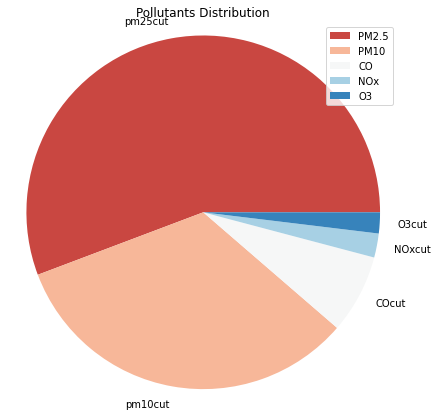

In [12]:
colors = sns.color_palette("RdBu", n_colors=len(pie))

# Create pie chart
labels = ['PM2.5','PM10','CO','NOx','O3']

rcParams['figure.figsize'] = 7,7
plt.pie(pie, labels=pie.index, colors=colors)


# Add legend
plt.legend(labels, loc="best")

# Modify labels
plt.title("Pollutants Distribution")
plt.axis('equal')

# Show plot
plt.show()



In [13]:
colors

[(0.7893886966551327, 0.2768166089965398, 0.2549019607843137),
 (0.9686274509803922, 0.7176470588235293, 0.5999999999999999),
 (0.9657054978854287, 0.9672433679354094, 0.9680891964628989),
 (0.654901960784314, 0.8143790849673205, 0.8941176470588236),
 (0.21568627450980393, 0.5141868512110727, 0.7328719723183391)]

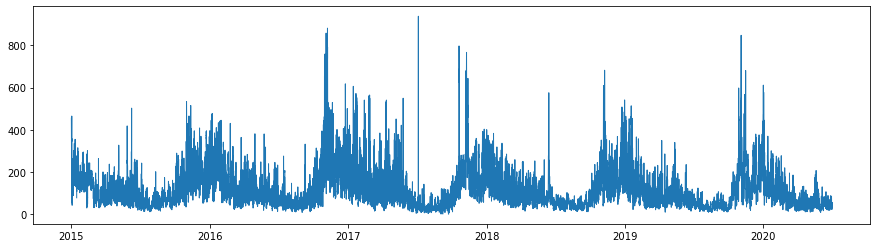

In [14]:
plt.figure(figsize=(15,4))
plt.plot(delhi_hour['DT'],(delhi_hour['PM2.5']), linewidth=1)

In [15]:
delhi_daily = delhi_hour.groupby(pd.Grouper(key='DT', freq='D')).mean()
delhi_pm25 = delhi_daily['PM2.5']

In [16]:
delhi_pm25.isna().sum()

2

In [17]:
#delhi_pm25.loc[delhi_pm25.isna()] = list(map(lambda x: delhi_pm25[delhi_pm25.loc[:x].last_valid_index()], delhi_pm25[delhi_pm25.isna()].index))

delhi_pm25.fillna(method='ffill', inplace=True)

In [18]:
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
delhi_pm25.to_csv('out.zip', index=False,
          compression=compression_opts) 

Text(0.5, 1.0, 'Daily Recorded Concentration of PM2.5')

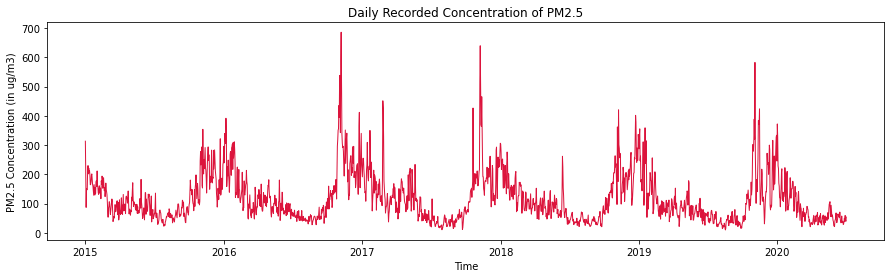

In [19]:
rcParams['figure.figsize'] = 15, 4
plt.plot(delhi_daily.index,(delhi_daily['PM2.5']), linewidth=1, color= 'crimson')
plt.xlabel("Time")
plt.ylabel("PM2.5 Concentration (in ug/m3)")
plt.title("Daily Recorded Concentration of PM2.5")

Text(0.5, 1.0, 'Log Daily Recorded Concentration of PM2.5')

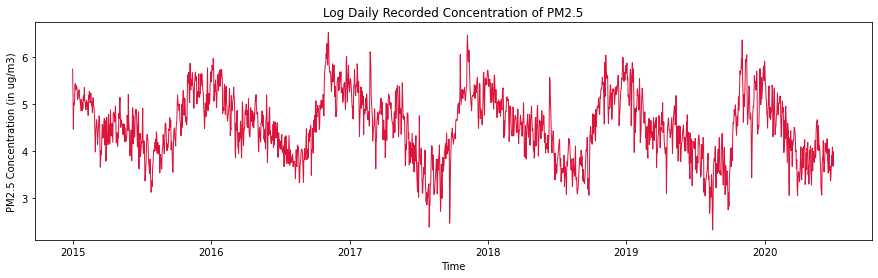

In [20]:
rcParams['figure.figsize'] = 15, 4
plt.plot(np.log(delhi_pm25), linewidth=1, color= 'crimson')
plt.xlabel("Time")
plt.ylabel("PM2.5 Concentration (in ug/m3)")
plt.title("Log Daily Recorded Concentration of PM2.5")

In [21]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [22]:
test_stationarity(np.log(delhi_pm25))

Results of Dickey-Fuller Test:
Test Statistic                   -3.086209
p-value                           0.027591
#Lags Used                       18.000000
Number of Observations Used    1990.000000
Critical Value (1%)              -3.433640
Critical Value (5%)              -2.862993
Critical Value (10%)             -2.567544
dtype: float64


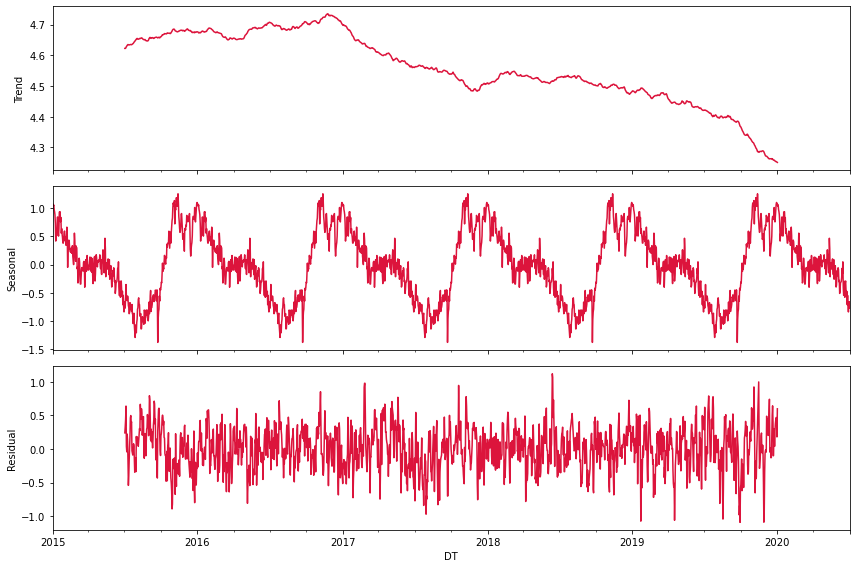

In [23]:
rcParams['figure.figsize'] = 20, 20
result = seasonal_decompose(np.log(delhi_pm25), model='additive', period=365)
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(12,8))

result.trend.plot(ax=axes[0], legend=False, color='crimson')
axes[0].set_ylabel('Trend')

result.seasonal.plot(ax=axes[1], legend=False, color='crimson')
axes[1].set_ylabel('Seasonal')

result.resid.plot(ax=axes[2], legend=False, color='crimson')
axes[2].set_ylabel('Residual')

plt.tight_layout()
plt.show()

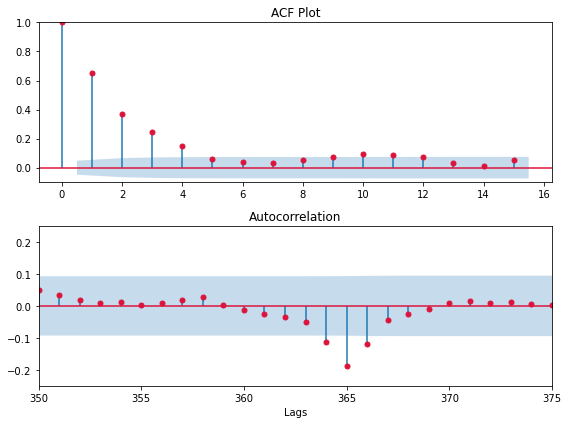

In [24]:
resids = result.resid

rcParams['figure.figsize'] = 15, 4
fig, (ax1,ax2) = plt.subplots(ncols=1, nrows=2, figsize=(8,6))

plot_acf(resids.dropna(), lags = 15 , ax = ax1, color = 'crimson')
ax1.set_title('ACF Plot')
ax1.set_ylim(-0.1,1)

plot_acf(resids.dropna(), lags = 400, ax = ax2, color = 'crimson')
ax2.set_xlim(350,375)
ax2.set_ylim(-0.250,0.250)

ax2.set_xlabel('Lags')

fig.tight_layout()

# show the plot
plt.show()

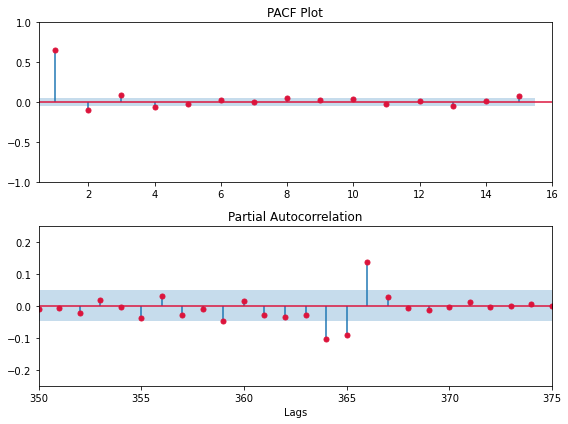

In [25]:
rcParams['figure.figsize'] = 15, 4
fig, (ax1,ax2) = plt.subplots(ncols=1, nrows=2, figsize=(8,6))

plot_pacf(resids.dropna(), lags = 15 , ax = ax1, color = 'crimson')
ax1.set_xlim(0.5,16)
ax1.set_title('PACF Plot')


plot_pacf(resids.dropna(), lags = 400, ax = ax2, color = 'crimson')
ax2.set_xlim(350,375)
ax2.set_ylim(-0.250,0.250)

ax2.set_xlabel('Lags')

fig.tight_layout()

# show the plot
plt.show()